In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from pathlib import Path

plt.rcParams["figure.figsize"] = (14,6)
plt.rcParams["axes.grid"] = True


/Users/mac/Documents/kaim/brent-oil-bayesian-change-point/env/lib/python3.10/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
DATA_PATH = Path("../data/raw/BrentOilPrices.csv")

df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df.head()


/var/folders/nf/drxnv59536v7bnknmx3c_1zw0000gn/T/ipykernel_35425/513374020.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


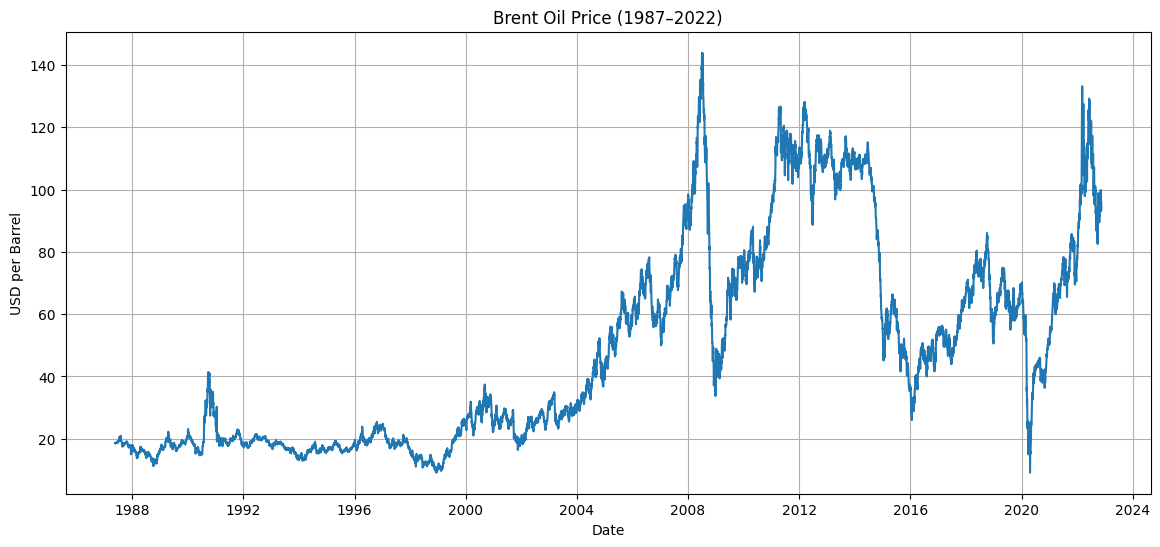

In [3]:
plt.plot(df["Date"], df["Price"])
plt.title("Brent Oil Price (1987–2022)")
plt.xlabel("Date")
plt.ylabel("USD per Barrel")
plt.show()


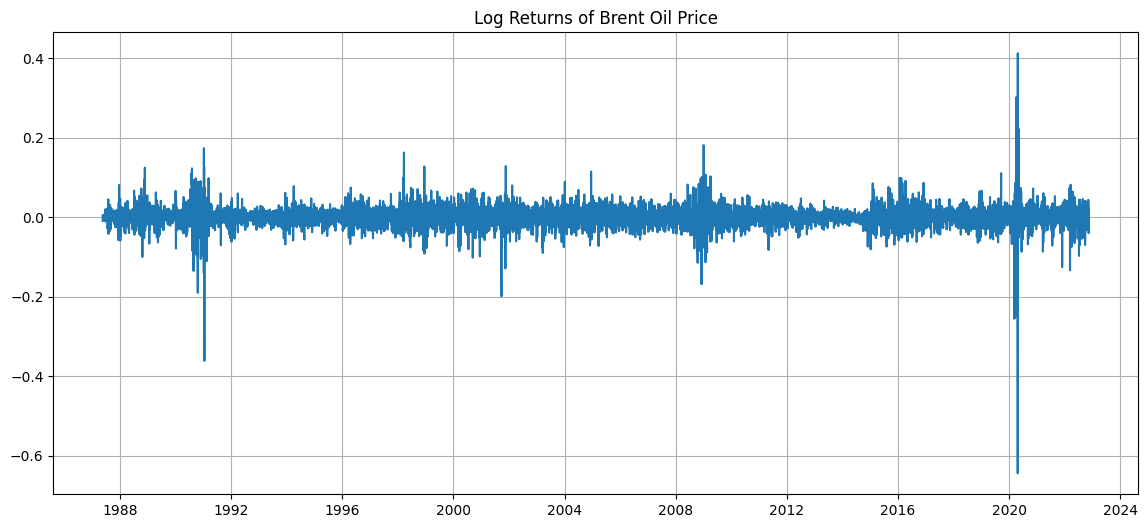

In [4]:
df["log_return"] = np.log(df["Price"]).diff()

plt.plot(df["Date"], df["log_return"])
plt.title("Log Returns of Brent Oil Price")
plt.show()


In [5]:
price = df["Price"].values
n = len(price)


In [6]:
with pm.Model() as model:

    # Switch point prior
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)

    # Means before and after
    mu_1 = pm.Normal("mu_1", mu=price.mean(), sigma=20)
    mu_2 = pm.Normal("mu_2", mu=price.mean(), sigma=20)

    # Shared volatility
    sigma = pm.HalfNormal("sigma", sigma=10)

    # Switch function
    mu = pm.math.switch(tau >= np.arange(n), mu_1, mu_2)

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=price)


In [7]:
with model:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        target_accept=0.95,
        return_inferencedata=True
    )


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 60 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
az.summary(trace, round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4519.79,3.26,4513.00,4525.00,0.11,0.09,838.98,992.30,1.0
mu_1,21.42,0.28,20.90,21.92,0.00,0.00,3486.10,2841.71,1.0
mu_2,75.61,0.27,75.14,76.17,0.00,0.00,3745.35,2527.41,1.0
sigma,18.59,0.14,18.33,18.85,0.00,0.00,3725.94,2426.17,1.0


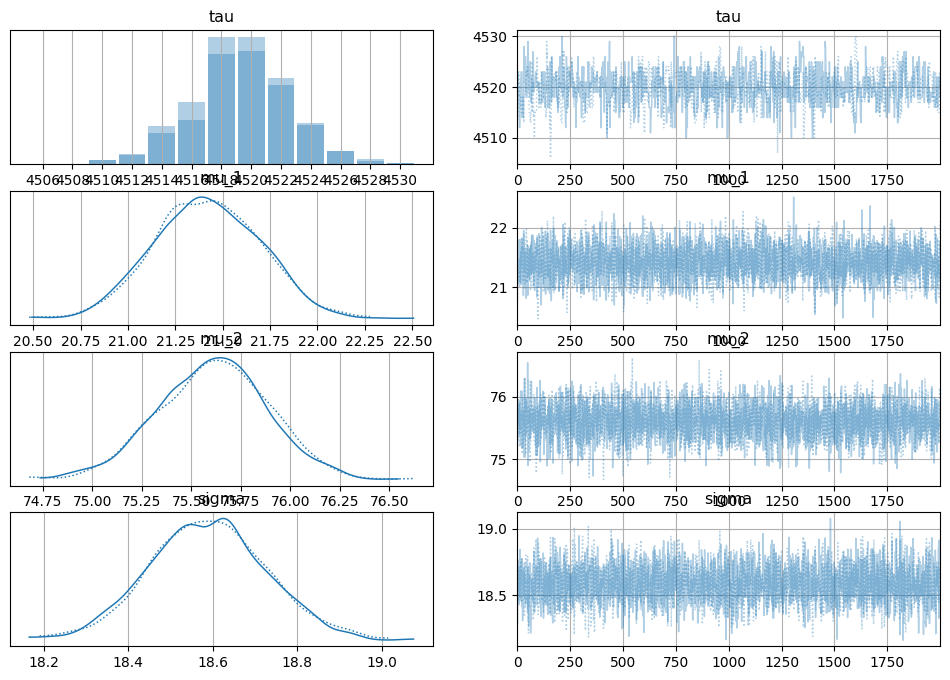

In [9]:
az.plot_trace(trace)
plt.show()


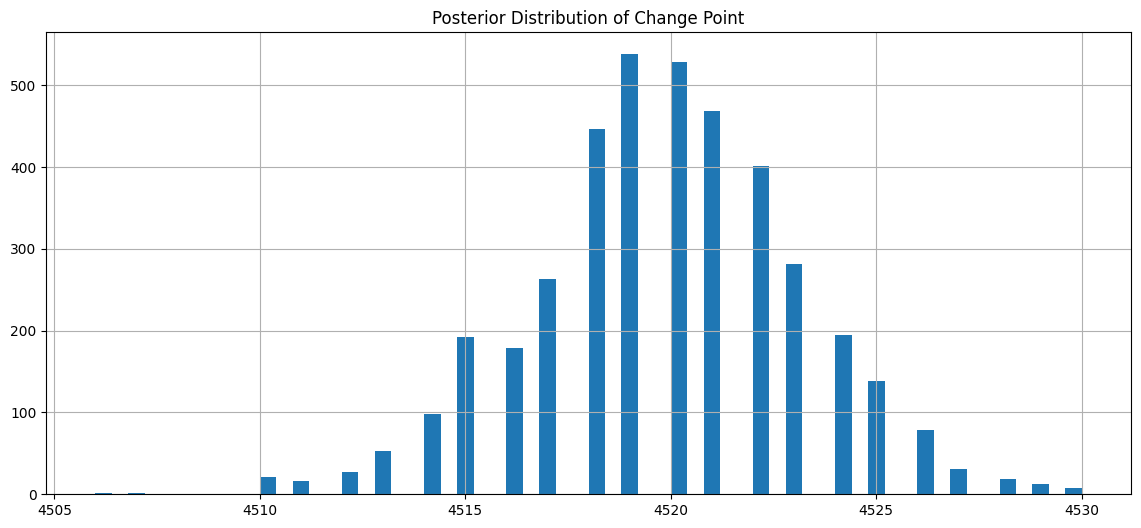

In [10]:
tau_samples = trace.posterior["tau"].values.flatten()

plt.hist(tau_samples, bins=60)
plt.title("Posterior Distribution of Change Point")
plt.show()


In [11]:
estimated_tau = int(np.median(tau_samples))
change_date = df.loc[estimated_tau, "Date"]

change_date


Timestamp('2005-02-23 00:00:00')

In [12]:
mu1_samples = trace.posterior["mu_1"].values.flatten()
mu2_samples = trace.posterior["mu_2"].values.flatten()

mean_before = mu1_samples.mean()
mean_after = mu2_samples.mean()

percent_change = ((mean_after - mean_before) / mean_before) * 100

mean_before, mean_after, percent_change


(np.float64(21.420120384158537),
 np.float64(75.60800384831),
 np.float64(252.97655891899961))

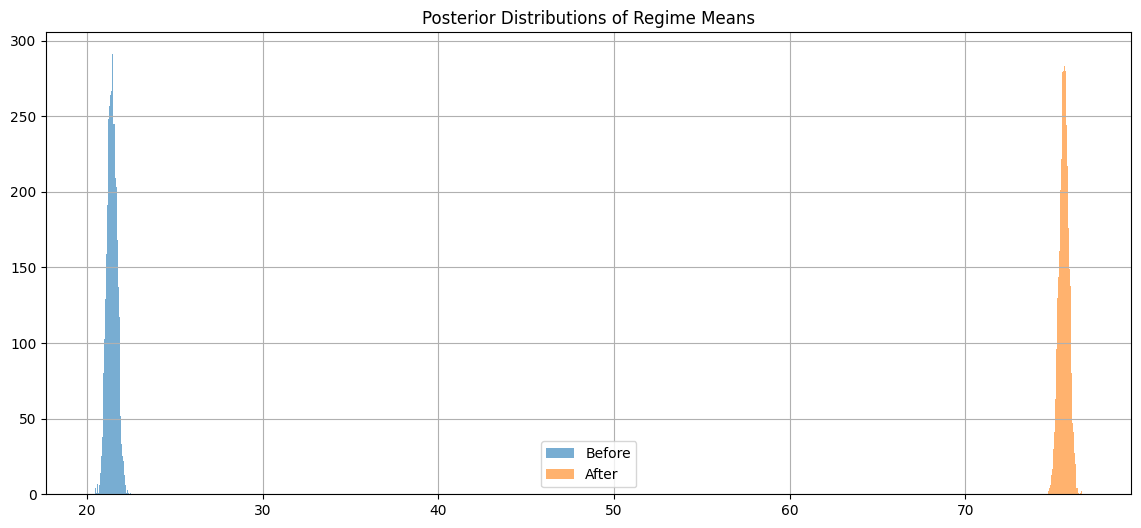

In [13]:
plt.hist(mu1_samples, bins=40, alpha=0.6, label="Before")
plt.hist(mu2_samples, bins=40, alpha=0.6, label="After")
plt.legend()
plt.title("Posterior Distributions of Regime Means")
plt.show()


In [16]:
events = pd.read_csv("../events/oil_market_events.csv")
events["Date"] = pd.to_datetime(events["Date"])
events


,Date,Event,Category
0,1990-08-02,Iraq invades Kuwait (Gulf War),Geopolitical Conflict
1,1997-07-02,Asian Financial Crisis begins,Financial Crisis
2,2001-09-11,September 11 Attacks,Geopolitical Shock
3,2003-03-20,Iraq War begins,Geopolitical Conflict
4,2008-09-15,Lehman Brothers Collapse (Global Financial Cri...,Financial Crisis
5,2010-04-20,Deepwater Horizon Oil Spill,Supply Shock
6,2011-02-15,Arab Spring unrest spreads,Geopolitical Instability
7,2014-11-27,OPEC decides not to cut production,OPEC Policy
8,2016-01-16,Iran sanctions lifted,Sanctions Policy
9,2018-05-08,US withdraws from Iran nuclear deal,Sanctions Policy


In [17]:
events.sort_values("Date")


,Date,Event,Category
0,1990-08-02,Iraq invades Kuwait (Gulf War),Geopolitical Conflict
1,1997-07-02,Asian Financial Crisis begins,Financial Crisis
2,2001-09-11,September 11 Attacks,Geopolitical Shock
3,2003-03-20,Iraq War begins,Geopolitical Conflict
4,2008-09-15,Lehman Brothers Collapse (Global Financial Cri...,Financial Crisis
5,2010-04-20,Deepwater Horizon Oil Spill,Supply Shock
6,2011-02-15,Arab Spring unrest spreads,Geopolitical Instability
7,2014-11-27,OPEC decides not to cut production,OPEC Policy
8,2016-01-16,Iran sanctions lifted,Sanctions Policy
9,2018-05-08,US withdraws from Iran nuclear deal,Sanctions Policy
